In [ ]:
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from skimage.util import random_noise
import math, re, os, cv2
from skimage.transform import rotate, AffineTransform, warp
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# 1. Importing the data and a little description:

In [ ]:
pure_spinach_path='Pure pistachios'
adulterated_pistachio_paths = {
    '10%': '10% spinach adulterated pistachios',
    '20%': '20% spinach adulterated pistachios',
    '30%': '30% spinach adulterated pistachios',
    '40%': '40% spinach adulterated pistachios',
    '50%': '50% spinach adulterated pistachios'
}

The dataset consists of images of pistachios, categorized into two main groups: **pure pistachios** and **spinach-adulterated pistachios.** The adulterated pistachios are further divided into subsets based on the percentage of spinach mixed with the pistachios.
* 10% Spinach Adulteration
* 20% Spinach Adulteration
* 30% Spinach Adulteration
* 40% Spinach Adulteration
* 50% Spinach Adulteration


**Goal of the project**: The goal is to create **an autoencoder for anomaly detection** using this dataset, which will utilize a threshold to identify adulterated pistachios. By training on pure pistachios, the autoencoder will flag images that deviate significantly as adulterated examples.

In [ ]:
#This function is used to load images from different directories,resize
#them to the chosen resolution and normalize them
def load_images_from_directory(directory_path, targetsize):
    images = []
    img_list = os.listdir(directory_path)
    for i in tqdm(img_list):
        img = tf.keras.preprocessing.image.load_img(directory_path + '/' + str(i), target_size=targetsize[:2])
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0 #Normalization to make values between 0 and 1
        images.append(img)
    return np.array(images)

In [ ]:
targetsize=(256,256,3)

## Loading `Pure Pistachio` images which will be our training images

In [ ]:
training_images=load_images_from_directory(pure_spinach_path, targetsize)

100%|██████████| 201/201 [00:00<00:00, 293.14it/s]


## Plotting some of `training_images`

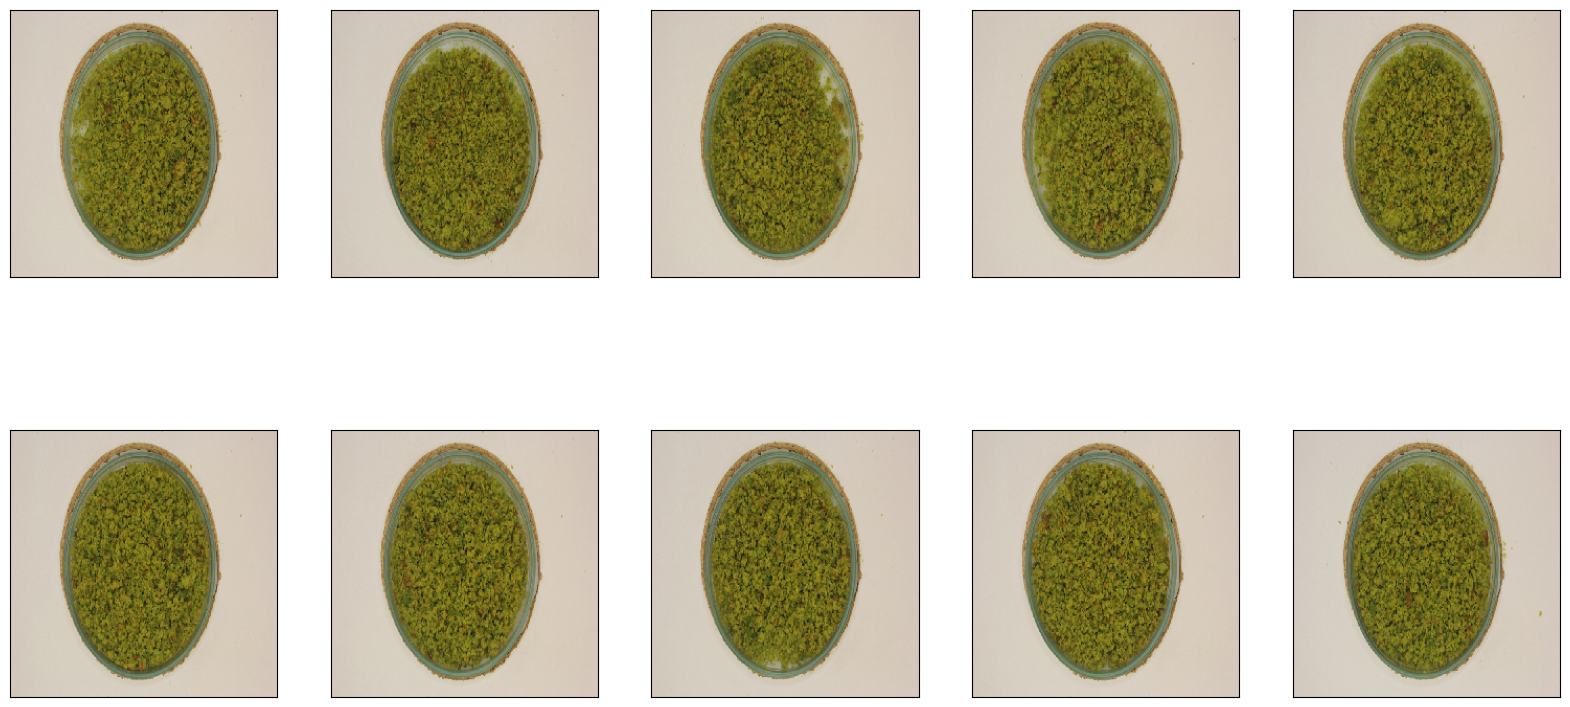

In [ ]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(training_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(training_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 2. Data Augmentation:

In [ ]:
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

def sharpen(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

In [ ]:
aug_images=[]
for i in tqdm(training_images):
    img = h_flip(i)
    aug_images.append(img)
for i in tqdm(training_images):
    img = v_flip(i)
    aug_images.append(img)
aug_images = np.array(aug_images)

100%|██████████| 201/201 [00:00<00:00, 276502.17it/s]


In [ ]:
training_images=np.concatenate((training_images,aug_images),axis=0)

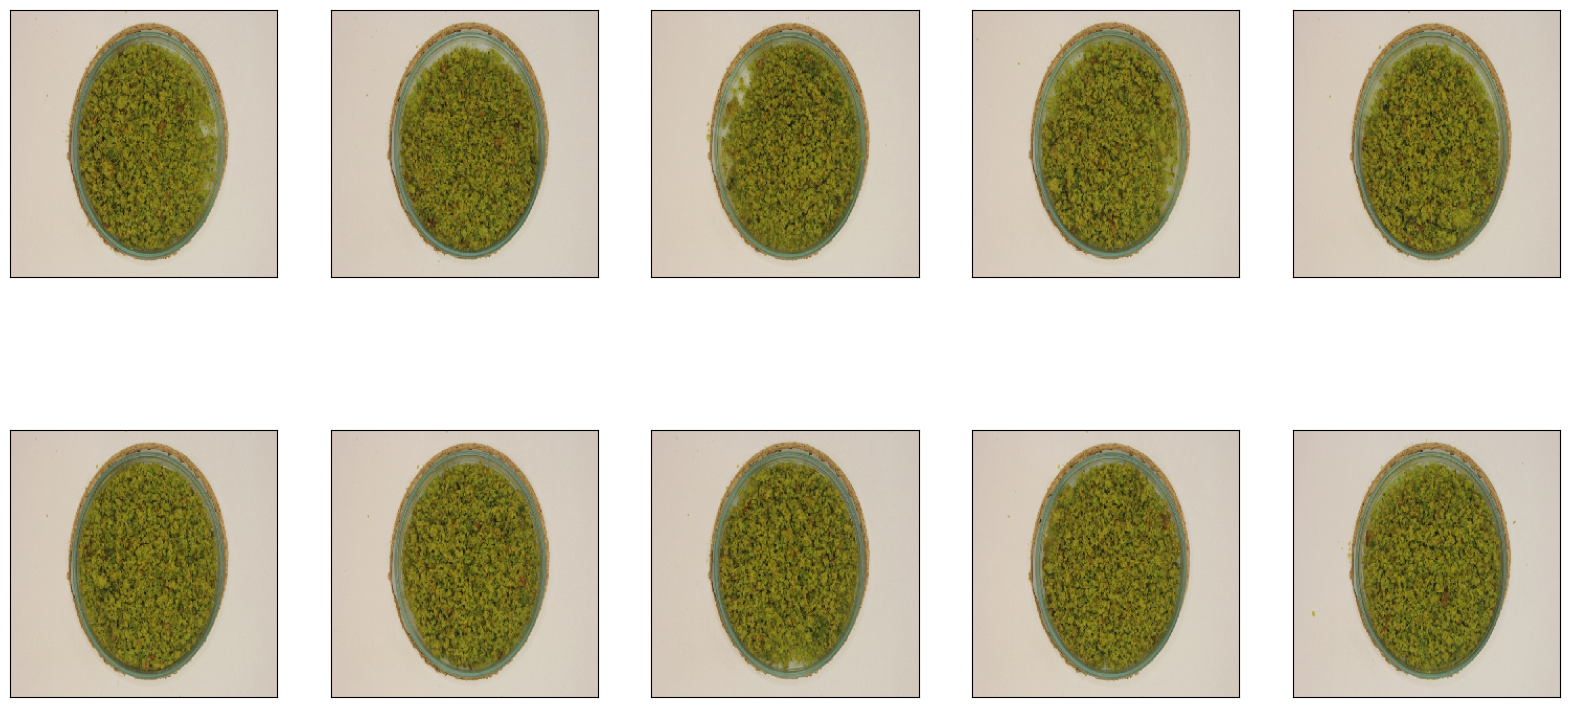

In [ ]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(aug_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(aug_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 3. Model, training and evaluation:
## 3.1. Model Architecture:
This model architecture is inspired from VGG19; which is is a convolutional neural network that is 19 layers deep. The pretrained model is used to classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.
![image.png](attachment:645b1844-111d-4e59-b7f8-9dc2c56e6da3.png)

![image.png](attachment:f9a82e02-f3b7-4eb1-984f-6be16a0588f9.png)

In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        #encoder
        self.encoder = Sequential([
            Conv2D(128, (3,3), activation='relu', padding='same',input_shape=targetsize),
            MaxPooling2D((2,2), padding='same'),
            Conv2D(64, (3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2), padding='same'),
            Conv2D(32, (3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2), padding='same'),
            Conv2D(16, (3,3), activation='relu', padding='same'),
            MaxPooling2D((2,2), padding='same')
])
        self.decoder = Sequential([
            Conv2D(16, (3,3), activation='relu', padding='same'),
            UpSampling2D((2,2)),
            Conv2D(32, (3,3), activation='relu', padding='same'),
            UpSampling2D((2,2)),
            Conv2D(64, (3,3), activation='relu', padding='same'),
            UpSampling2D((2,2)),
            Conv2D(128, (3,3), activation='relu', padding='same'),
            UpSampling2D((2,2)),
            Conv2D(3,(3,3),activation='sigmoid',padding='same')])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

* **The encoder** comprises a series of convolutional (Conv2D) and max pooling (MaxPooling2D) layers to downsample the input images and capture their essential features.

![image.png](attachment:df9c5e70-5476-42d5-94d5-cdabca4d41d1.png)!

* Similarly, **the decoder** consists of convolutional (Conv2D) and upsampling (UpSampling2D) layers to reconstruct the input images from the encoded representations.

![image.png](attachment:ab9fd88b-7096-41ab-9bae-990128506495.png)

* The activation function used in the convolutional layers is ReLU, except for the last layer of the decoder, which uses a sigmoid activation function to ensure output pixel values are in the range  [0, 1].

In [ ]:
autoencoder = AnomalyDetector()

In [ ]:
autoencoder.summary()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "anomaly_detector_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │       100,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,464 (392.44 KB)

 Trainable params: 100,464 (392.44 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,464 (392.44 KB)

 Trainable params: 100,464 (392.44 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer=Adam(learning_rate=0.003), loss=MeanSquaredError())

* The autoencoder is compiled using the adam optimizer, a learning rate =0.003 and MSE as loss function.

## 3.2. Model training:

In [ ]:
history=autoencoder.fit(training_images, training_images, epochs=150, batch_size=64, validation_split=0.1,verbose=2, shuffle=True)

Epoch 1/150
9/9 - 98s - 11s/step - loss: 0.0685 - val_loss: 0.0528
Epoch 2/150
9/9 - 5s - 545ms/step - loss: 0.0418 - val_loss: 0.0277
Epoch 3/150
9/9 - 5s - 542ms/step - loss: 0.0215 - val_loss: 0.0133
Epoch 4/150
9/9 - 5s - 538ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 5/150
9/9 - 5s - 536ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 6/150
9/9 - 5s - 540ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 7/150
9/9 - 5s - 536ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/150
9/9 - 5s - 546ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/150
9/9 - 5s - 536ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/150
9/9 - 5s - 536ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 11/150
9/9 - 5s - 540ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 12/150
9/9 - 5s - 539ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 13/150
9/9 - 5s - 538ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 14/150
9/9 - 5s - 541ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 15/150
9/9 - 5s - 527ms/step - loss: 0

## Visualisation of Loss by epochs:

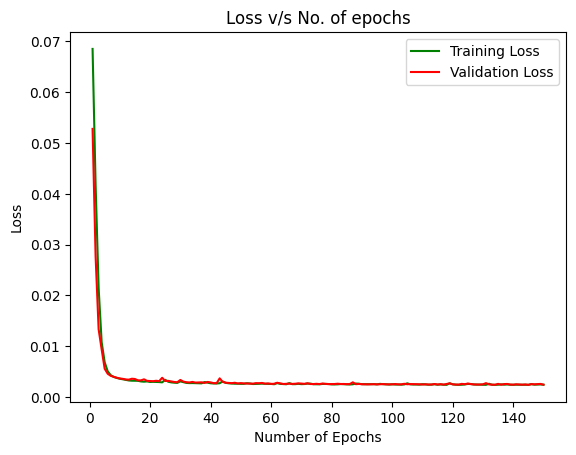

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss by No. of epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It seems like the model is training reasonably well, with the training loss (loss) and validation loss (val_loss) decreasing over epochs. The model is learning to reconstruct the input images, as evidenced by the decreasing loss values.

## Generation for a randomly chosen image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


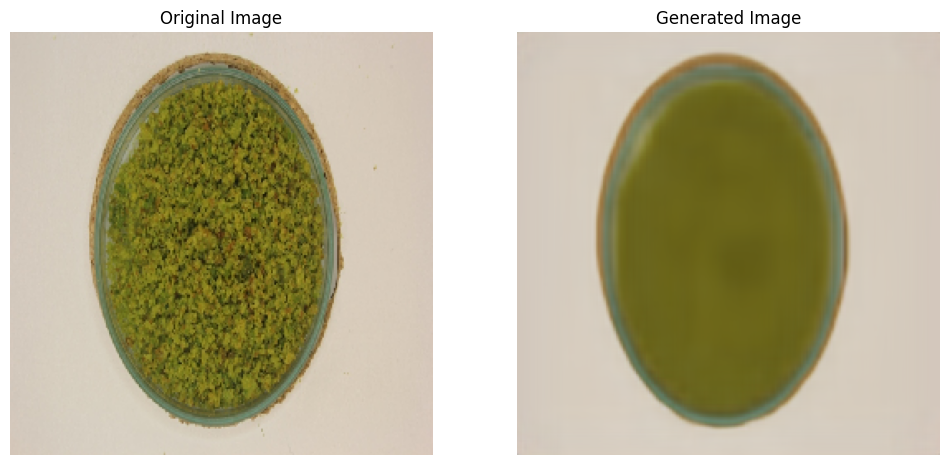

In [ ]:
# Step 1: Select a random image from all_images
random_index = np.random.randint(0, training_images.shape[0])
original_image = training_images[random_index]

# Step 2: Use the autoencoder to generate the output for this image
generated_image = autoencoder.predict(np.expand_dims(original_image, axis=0))

# Step 3: Plot the original image and the generated image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Plot generated image
axes[1].imshow(generated_image[0])
axes[1].set_title("Generated Image")
axes[1].axis("off")

plt.show()

## Distribution of reconstruction error by level of fraud:

In [ ]:
def calculate_reconstruction_error(autoencoder, images):
    reconstructed_images = autoencoder.predict(images)
    reconstruction_errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))
    return reconstruction_errors

100%|██████████| 204/204 [00:00<00:00, 230.56it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


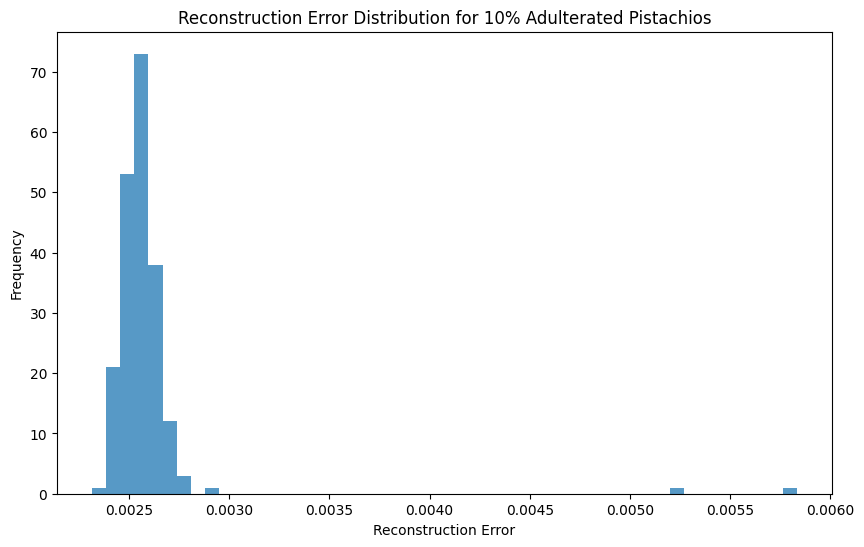

100%|██████████| 200/200 [00:00<00:00, 231.45it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


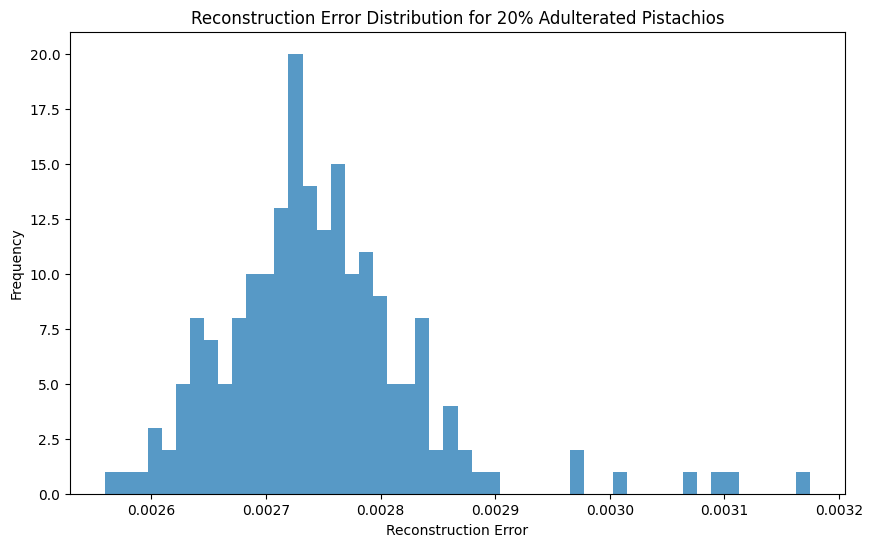

100%|██████████| 205/205 [00:00<00:00, 208.62it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


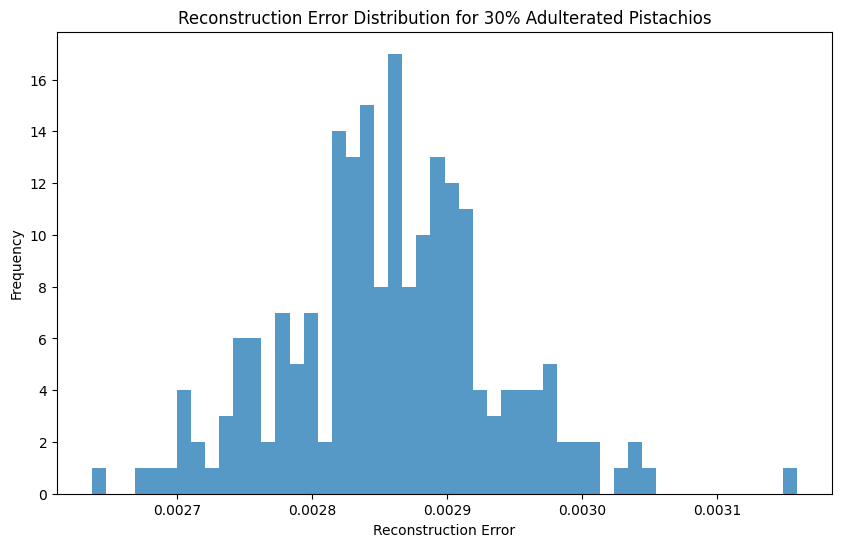

100%|██████████| 205/205 [00:00<00:00, 224.35it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


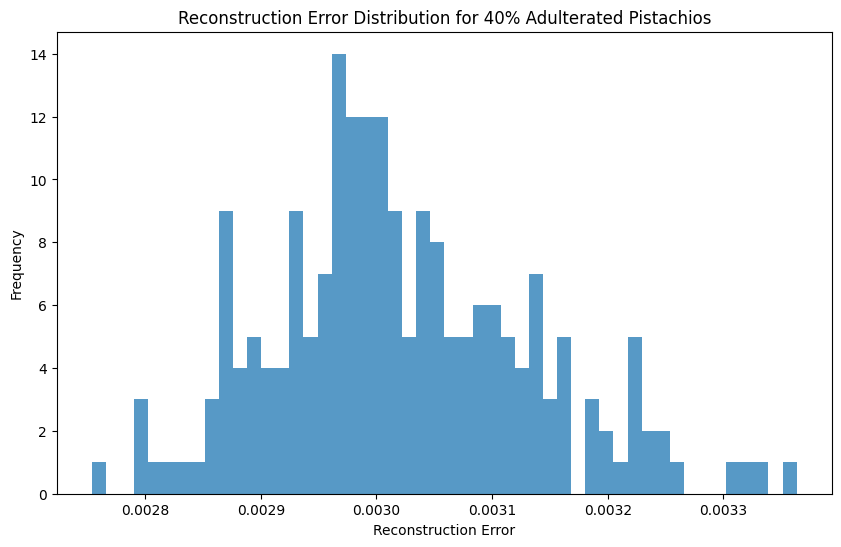

100%|██████████| 205/205 [00:00<00:00, 233.84it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


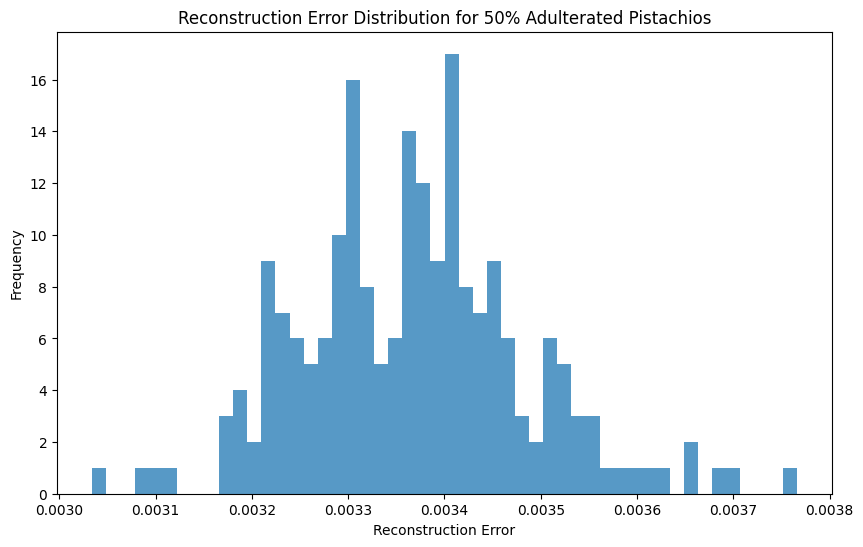

In [ ]:
for level, path in adulterated_pistachio_paths.items():
    adulterated_images = load_images_from_directory(path, targetsize)
    reconstruction_errors = calculate_reconstruction_error(autoencoder, adulterated_images)
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors, bins=50, alpha=0.75)
    plt.title(f'Reconstruction Error Distribution for {level} Adulterated Pistachios')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.show()

The visualizations reveal that: as the amount of spinach adulteration in the pistachio samples increases, the reconstruction error does as well. **This means the model struggles more to accurately reconstruct heavily adulterated images. In simpler terms, the higher the spinach content, the harder it is for the model to tell what's going on in the images.**

In [ ]:
train_loss = calculate_reconstruction_error(autoencoder, training_images)

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


In [ ]:
print(np.mean(train_loss))
print(np.std(train_loss))

0.0023711708
9.7388525e-05


In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0024685594


In [ ]:
all_images = np.empty((0, 256, 256, 3))
all_images_labels=[]
pure_images=load_images_from_directory(pure_spinach_path, targetsize)
all_images = np.concatenate((all_images, pure_images), axis=0)
all_images_labels.extend([0] * len(pure_images))
for label, path in adulterated_pistachio_paths.items():
    images = load_images_from_directory(path, targetsize)
    all_images = np.concatenate((all_images, images), axis=0)
    all_images_labels.extend([1] * len(images))
all_images_labels = np.array(all_images_labels)

100%|██████████| 205/205 [00:00<00:00, 221.82it/s]


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def predict(model, data, threshold):
    predictions = []
    loss=calculate_reconstruction_error(model,data)
    batch_predictions = tf.math.greater(loss, threshold)
    predictions.append(batch_predictions)
    return np.concatenate(predictions)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("F1 score = {}".format(f1_score(labels, predictions)))


In [ ]:
preds = predict(autoencoder, all_images, threshold)
preds = np.array(preds).astype(int)
all_images_labels = np.array(all_images_labels).astype(int)
print_stats(preds, all_images_labels)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Accuracy = 0.9622950819672131
Precision = 0.9840796019900497
Recall = 0.9705593719332679
F1 score = 0.9772727272727273


**Overall, these evaluation metrics underscore the reliability and efficacy of the anomaly detection system in distinguishing between pure and spinach-adulterated pistachios.**